In [49]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import splitext
from typing import Optional, List, Tuple, Dict

In [13]:
# functions

def read_triples(path: str) -> List[Tuple[str, str, str]]:
    triples = []

    tmp = splitext(path)
    ext = tmp[1] if len(tmp) > 1 else None

    with open(path, 'rt') as f:
        for line in f.readlines():
            if ext is not None and ext.lower() == '.tsv':
                s, p, o = line.split('\t')
            else:
                s, p, o = line.split()
            triples += [(s.strip(), p.strip(), o.strip())]
    return triples

In [113]:
# load dataset

DATASET = "umls"

triples_train = read_triples(f"./data/{DATASET}/train.tsv")
triples_dev = read_triples(f"./data/{DATASET}/dev.tsv")
triples_test = read_triples(f"./data/{DATASET}/test.tsv")
triples_all = triples_train + triples_dev + triples_test

In [114]:
# make set set of entities and predicates, and count number of each

def get_kg_stats_dict(triples, split_str):
    subject_set = {s for (s, _, _) in triples}
    object_set = {o for (_, _, o) in triples}
    entity_set = subject_set | object_set
    relation_set = {p for (_, p, _) in triples}
    
    stats = {"Split": split_str,
            "Entities count": len(entity_set),
            "Subjects count": len(subject_set),
            "Objects count": len(object_set),
            "Relations count": len(relation_set),
            "Triples count": len(triples)
            }
    
    return stats

def get_kg_stats_df(triples_all, triples_train, triples_dev, triples_test):
    
    stats_all = get_kg_stats(triples_all, "all")
    stats_train = get_kg_stats(triples_train, "train")
    stats_dev = get_kg_stats(triples_dev, "dev")
    stats_test = get_kg_stats(triples_test, "test")
    
    df_stats = pd.DataFrame()
    for stats_dict in [stats_all, stats_train, stats_dev, stats_test]:
        df_stats = df_stats.append(stats_dict, ignore_index=True)
    
    return df_stats
    
df_stats = tabulate_kg_stats(triples_all, triples_train, triples_dev, triples_test)

In [115]:
df_stats

,Entities count,Objects count,Relations count,Split,Subjects count,Triples count
0,135.0,132.0,46.0,all,135.0,6529.0
1,135.0,132.0,46.0,train,135.0,5216.0
2,131.0,112.0,36.0,dev,120.0,652.0
3,131.0,109.0,36.0,test,116.0,661.0


In [116]:
# Check for fully duplicated triples

print(f"Number of duplicated triples: {len(triples_all)-len(set(triples_all))}")

Number of duplicated triples: 0


In [117]:
print("Data split overlaps via symmetric triples, i.e. triples with same relation but entities swapped\n")

# train-dev overlap via inverse relations (number of train triples for which the exact inverse exists in dev set)
inverted_dev = [(o, p, s) for (s, p, o) in triples_dev]
print(f"train-dev: {len(set(triples_train) & set(inverted_dev))}/{len(triples_train)}")

# train-test overlap via inverse relations (number of train triples for which the exact inverse exists in test set)
inverted_test = [(o, p, s) for (s, p, o) in triples_test]
print(f"train-test: {len(set(triples_train) & set(inverted_test))}/{len(triples_train)}")

# dev-test overlap via inverse relations (number of dev triples for which the exact inverse exists in test set)
print(f"dev_test: {len(set(triples_dev) & set(inverted_test))}/{len(triples_dev)}")

Data split overlaps via symmetric triples, i.e. triples with same relation but entities swapped

train-dev: 81/5216
train-test: 97/5216
dev_test: 9/652


In [139]:
# count frequencies of each entity and predicate, make df of number of each

def get_entity_relation_frequencies(triples):
    subject_set = {s for (s, _, _) in triples}
    object_set = {o for (_, _, o) in triples}
    entity_set = subject_set | object_set
    relation_set = {p for (_, p, _) in triples}
    
    entity_counts = {}        
    for entity in entity_set:
        entity_counts[entity] = 0
        for triple in triples:
            if entity == triple[0] or entity == triple[2]:
                entity_counts[entity] += 1
    
    relation_counts = {}        
    for relation in relation_set:
        relation_counts[relation] = 0
        for triple in triples:
            if relation == triple[1]:
                relation_counts[relation] += 1
    
    return entity_counts, relation_counts

entity_counts_train, relation_counts_train = get_entity_relation_frequencies(triples_train)

In [166]:
df_entity_counts = pd.DataFrame.from_dict({"entity_counts": entity_counts_train}).sort_values("entity_counts")
df_entity_counts

,entity_counts
language,3
functional_concept,6
molecular_sequence,7
carbohydrate_sequence,7
amino_acid_sequence,7
...,...
mental_or_behavioral_dysfunction,295
experimental_model_of_disease,299
disease_or_syndrome,300
pathologic_function,304


In [167]:
df_relation_counts = pd.DataFrame.from_dict({"relation_counts": relation_counts_train}).sort_values("relation_counts")
df_relation_counts

,relation_counts
derivative_of,1
practices,2
interconnects,2
conceptually_related_to,2
developmental_form_of,4
connected_to,4
adjacent_to,6
surrounds,6
manages,6
consists_of,9


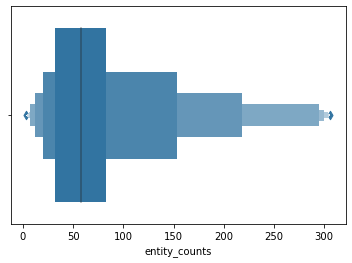

In [198]:
sns.boxenplot(x=df_entity_counts["entity_counts"])
plt.show()

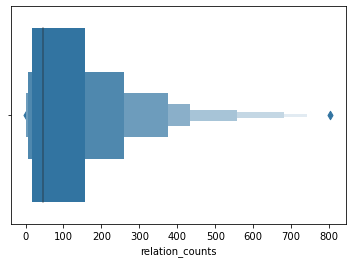

In [197]:
sns.boxenplot(x=df_relation_counts["relation_counts"])
plt.show()